In [4]:
from pydwf import DwfLibrary, DwfAnalogOutNode, DwfAnalogOutFunction
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from scipy.signal import correlate
import pandas as pd
from gmeasure import GMeasure

dwf = DwfLibrary()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Fixed component values (modify as needed)
# ============================================================
# First parallel RLC (at V1)
R1 = 100.864
L1 = 106.4e-3
C1 = 0.2196e-6

# Second parallel RLC (at V2)
R2 = 101.529
L2 = 107.1e-3
C2 = 0.2253e-6

# Third parallel RLC (at V3)
R3 = 101.457
L3 = 107.2e-3
C3 = 0.2306e-6

# ============================================================
# Impedances
# ============================================================
def Z_R(R): return R
def Z_L(w, L): return 1j * w * L
def Z_C(w, C): return 1 / (1j * w * C)

def parallel(a, b):
    return 1 / (1/a + 1/b)

# ============================================================
# Gain formula for asymmetric case
# ============================================================
def compute_gain(w, Cp, Cpp):   # Cp = C', Cpp = C''
    # Parallel RLCs
    Z1 = 1 / (1/R1 + 1/Z_L(w, L1) + 1/Z_C(w, C1))
    Z2 = 1 / (1/R2 + 1/Z_L(w, L2) + 1/Z_C(w, C2))
    Z3 = 1 / (1/R3 + 1/Z_L(w, L3) + 1/Z_C(w, C3))

    # Y = Z2 || (Z3 + 1/(jω C''))
    Y = parallel(Z2, Z3 + Z_C(w, Cpp))

    # Gain = Z3/(1/(jω C'') + Z3) * Y/(1/(jω C') + Y)
    G = ( Z3 / (Z3 + Z_C(w, Cpp)) ) * ( Y / (Y + Z_C(w, Cp)) )

    return np.abs(G)

In [ ]:
def identity(x):
    return x

def range_finder(signal):
    range_simple = np.ptp(signal)
    return range_simple

In [ ]:
def transfer_func(y):
    return (y - 0.03593075008361179)/10.024579938249904

In [ ]:
def measure_ac_coupled_cap_matrix(
    list_c1,
    list_c2,
    freq,
    v_in=1,
    n_meas=5,
    f_f=identity
):
    """
    Sweep across all ordered (C1, C2) combinations (in microfarads),
    ask for manual confirmation before each measurement,
    and store AC gain and voltage range results in matrix form.

    Order is relevant: (C1, C2) ≠ (C2, C1)
    Frequency is FIXED for all measurements.
    """

    list_c1 = np.array(list_c1)
    list_c2 = np.array(list_c2)

    n1 = len(list_c1)
    n2 = len(list_c2)

    # --- Output Matrices ---
    gain_matrix = np.zeros((n1, n2))
    gain_amp_matrix = np.zeros((n1, n2))
    gain_std_matrix = np.zeros((n1, n2))
    gain_amp_std_matrix = np.zeros((n1, n2))

    vin_matrix = np.zeros((n1, n2))
    vin_std_matrix = np.zeros((n1, n2))

    vout_matrix = np.zeros((n1, n2))
    vout_std_matrix = np.zeros((n1, n2))

    vout_amp_matrix = np.zeros((n1, n2))
    vout_amp_std_matrix = np.zeros((n1, n2))

    vout_transfer_amp_matrix = np.zeros((n1, n2))
    vout_transfer_amp_std_matrix = np.zeros((n1, n2))

    prefer_bool = None  # Device auto-detection only once

    # --- Full ordered capacitor sweep ---
    for i, c1 in enumerate(list_c1):
        for j, c2 in enumerate(list_c2):

            print(
                f"\n========== CAPACITOR SETUP REQUIRED ==========\n"
                f"Set:\n"
                f"   C1 = {c1} µF\n"
                f"   C2 = {c2} µF\n"
                f"   Frequency = {freq} Hz\n"
            )

            # --- USER CONFIRMATION LOOP ---
            while True:
                confirm = input("Are the correct capacitors installed? (y/n): ").strip().lower()
                if confirm == "y":
                    break
                else:
                    print("Waiting for correct setup...")

            print("\n✅ Setup confirmed. Starting measurement...\n")

            # --- Step 1: Measurement object ---
            gm = GMeasure(
                osc_channels2=[1, 1],
                osc_channels1=[1, 0],
                out_channels1=[1, 0],
                ad_2=2,
                v_out1=[v_in, 0],
                waveforms_1=["Sine", "DC"],
                supply=[0, 0],
                freq1=[freq, 0],
                wavelengths=2,
                prefer_first_device=prefer_bool
            )

            # --- First-ever measurement triggers device detection ---
            if prefer_bool is None:
                gm.measure2()
                prefer_bool = gm.response
                print(f"\n🔎 Device order detected: prefer_first_device = {prefer_bool}\n")

            # --- Step 2: repeated measurements ---
            gains, gains_amp = [], []
            vin_ranges, vout_ranges, vout_amp_ranges, vout2_transfer_ranges = [], [], [], []

            for k in range(n_meas):
                gm.measure2()

                v_1 = np.array(gm.data1[0])
                v_2 = np.array(gm.data2[0])
                v_3 = np.array(gm.data2[1])

                vin_range   = range_finder(v_1)
                vout_range  = range_finder(v_2)
                vout2_range = range_finder(v_3)
                vout2_transfer_range = f_f(vout2_range)

                gain     = vout_range / vin_range if vin_range != 0 else np.nan
                gain_amp = vout2_transfer_range / vin_range if vin_range != 0 else np.nan

                gains.append(gain)
                gains_amp.append(gain_amp)

                vin_ranges.append(vin_range)
                vout_ranges.append(vout_range)
                vout_amp_ranges.append(vout2_range)
                vout2_transfer_ranges.append(vout2_transfer_range)

            # --- Step 3: Store matrix values ---
            gain_matrix[i, j] = np.nanmean(gains)
            gain_std_matrix[i, j] = np.nanstd(gains)

            gain_amp_matrix[i, j] = np.nanmean(gains_amp)
            gain_amp_std_matrix[i, j] = np.nanstd(gains_amp)

            vin_matrix[i, j] = np.nanmean(vin_ranges)
            vin_std_matrix[i, j] = np.nanstd(vin_ranges)

            vout_matrix[i, j] = np.nanmean(vout_ranges)
            vout_std_matrix[i, j] = np.nanstd(vout_ranges)

            vout_amp_matrix[i, j] = np.nanmean(vout_amp_ranges)
            vout_amp_std_matrix[i, j] = np.nanstd(vout_amp_ranges)

            vout_transfer_amp_matrix[i, j] = np.nanmean(vout_amp_ranges)
            vout_transfer_amp_std_matrix[i, j] = np.nanstd(vout_amp_ranges)

            print(
                f"✅ C1 = {c1} µF | C2 = {c2} µF → "
                f"Gain = {gain_matrix[i, j]:.3f} ± {gain_std_matrix[i, j]:.3f}, "
                f"Gain Amp = {gain_amp_matrix[i, j]:.3f} ± {gain_amp_std_matrix[i, j]:.3f}"
            )

    # --- Final Return ---
    return {
        "C1_values": list_c1,
        "C2_values": list_c2,
        "frequency": freq,

        "gain_matrix": gain_matrix,
        "gain_std_matrix": gain_std_matrix,

        "gain_amp_matrix": gain_amp_matrix,
        "gain_amp_std_matrix": gain_amp_std_matrix,

        "vin_matrix": vin_matrix,
        "vin_std_matrix": vin_std_matrix,

        "vout_matrix": vout_matrix,
        "vout_std_matrix": vout_std_matrix,

        "vout_amp_matrix": vout_amp_matrix,
        "vout_amp_std_matrix": vout_amp_std_matrix,

        "device_preference": prefer_bool
    }


In [ ]:
C_2vals = [0.0010646,0.002223,0.004686, 0.007202, 0.010269,0.015652,0.02236,0.03408,0.04818, 0.0689,0.1096,0.2266,1.022,4.853, 9.822]
C_1vals = [0.0010334, 0.002182, 0.004648, 0.007183, 0.010050, 0.015652, 0.02193, 0.03367,0.04798, 0.0683,0.10316,0.2233,1.010, 4.853, 9.822 ]  # µF

results = measure_ac_coupled_cap_matrix(
    list_c1=C_1vals,
    list_c2=C_2vals,
    freq=5000,      # 1 kHz
    v_in=1,
    n_meas=10,
    f_f = transfer_func
)


========== CAPACITOR SETUP REQUIRED ==========
Set:
   C1 = 0.0010334 µF
   C2 = 0.0010646 µF
   Frequency = 5000 Hz



In [ ]:
from scipy.interpolate import griddata

def plot_gain_3d_scatter_log(results):
    """
    3D scatter plot of Gain vs ordered (C1, C2),
    plus 2D interpolation surface (translucent grid).
    """

    # Log-scale transform (as in your original)
    C1 = 1/np.log(results["C1_values"] * 1e-6)
    C2 = 1/np.log(results["C2_values"] * 1e-6)
    G   = results["gain_matrix"]
    Gamp = results["gain_amp_matrix"]

    # Build grid
    C1_grid, C2_grid = np.meshgrid(C1, C2, indexing="ij")

    x = C1_grid.flatten()
    y = C2_grid.flatten()
    z = G.flatten()
    z2 = Gamp.flatten()

    # -----------------------------------------------------------
    # 1) Build a finer interpolation grid for smooth translucent surface
    # -----------------------------------------------------------
    x_fine = np.linspace(min(x), max(x), 80)
    y_fine = np.linspace(min(y), max(y), 80)
    X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

    Z_fine  = griddata((x, y), z, (X_fine, Y_fine), method='cubic')
    Z2_fine = griddata((x, y), z2, (X_fine, Y_fine), method='cubic')

    # ===========================================
    # Plot 1 — Normal Gain
    # ===========================================
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # scatter points
    sc = ax.scatter(x, y, z, c=z, s=30)
    fig.colorbar(sc, ax=ax, label="Gain")

    # translucent interpolated surface
    ax.plot_surface(
        X_fine, Y_fine, Z_fine,
        alpha=0.35,
        cmap="viridis",
        linewidth=0,
        antialiased=True
    )

    ax.set_xlabel("log C1 (µF)")
    ax.set_ylabel("log C2 (µF)")
    ax.set_zlabel("Gain")
    ax.set_title("3D Scatter + Interpolated Surface: Gain")

    plt.tight_layout()
    plt.show()

    # ===========================================
    # Plot 2 — Amplified Gain
    # ===========================================
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    sc = ax.scatter(x, y, z2, c=z2, s=30)
    fig.colorbar(sc, ax=ax, label="Gain (Amp)")

    ax.plot_surface(
        X_fine, Y_fine, Z2_fine,
        alpha=0.35,
        cmap="viridis",
        linewidth=0,
        antialiased=True
    )

    ax.set_xlabel("log C1 (µF)")
    ax.set_ylabel("log C2 (µF)")
    ax.set_zlabel("Gain (Amp)")
    ax.set_title("3D Scatter + Interpolated Surface: Gain(Amp)")

    plt.tight_layout()
    plt.show()


In [ ]:
data = np.load("cap_sweep_data.npz", allow_pickle=True)

gain_matrix = data["gain_matrix"]
vin_matrix = data["vin_matrix"]
C1_values = data["C1_values"]
C2_values = data["C2_values"]
v_out = data["vout_matrix"]

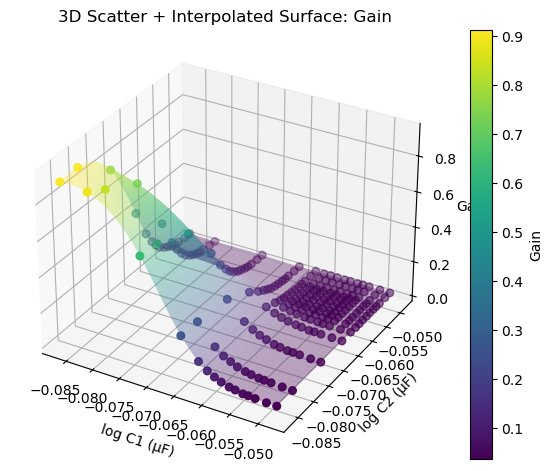

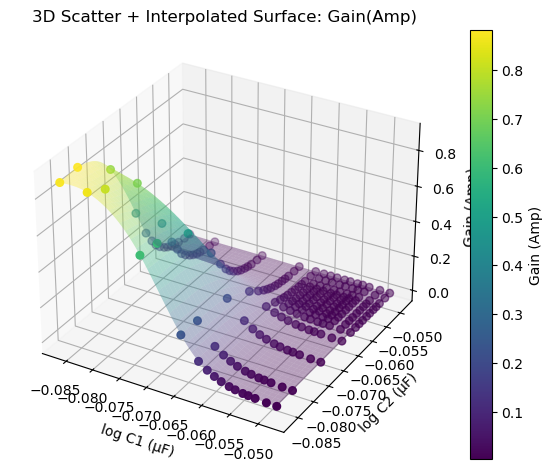

In [ ]:
plot_gain_3d_scatter_log(data)